In [43]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kstest, ks_2samp, pearsonr
import seaborn as sns
import tensorflow as tf
import numpy as np
import os
import random
import seaborn as sns
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.model_selection import  train_test_split
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kstest, ks_2samp, pearsonr

def plot_feature_stationary(feature_name, lw=3, figsize = (15, 10)):
    plt.figure(figsize = figsize)
    plt.plot(d_stationary[feature_name], linewidth = lw, color = "darkorange")
    anomaly_indices=np.argwhere(y_cat[:,0] == 1)[:,0]
    lb = np.min(d_stationary[feature_name])-0.1
    ub = np.abs(lb) + np.max(d_stationary[feature_name])+0.1
    plt.bar(x=anomaly_indices, height=ub, bottom = lb)
    plt.show()

def plot_feature(feature_name, lw=3, figsize = (15, 10)):
    plt.figure(figsize = figsize)
    plt.plot(d[feature_name], linewidth = lw, color = "darkorange")
    anomaly_indices=np.argwhere(y_cat[:,0] == 1)[:,0]
    lb = np.min(d[feature_name])-0.1
    ub = np.abs(lb) + np.max(d[feature_name])+0.1
    plt.bar(x=anomaly_indices, height=ub, bottom = lb)
    plt.show()

# Random seed for reproducibility
# seed = 42

# random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# tf.compat.v1.set_random_seed(seed)

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [44]:
mat = scipy.io.loadmat('EWS.mat')
names = list(mat.keys())[3:-2]
y = mat["Y"]
y_cat = np.zeros_like(y, dtype = int)
y_cat[y[:,0]==1.0,0] = 1
col = []
times = np.arange(y.shape[0])
for ipsilon in y:
    if ipsilon == 1.0:
        col.append("red")
    else:
        col.append("blue")
d = {}
for i, name in enumerate(names):
    if name != "None":
        d[name] = mat[names[i]]
Indices_Currencies = ["XAUBGNL", "BDIY", "CRY", "Cl1", "DXY", "EMUSTRUU", "GBP", "JPY", "LF94TRUU", "LF98TRUU", "LG30TRUU", "LMBITR", "LP01TREU", "LUACTRUU", "LUMSTRUU", "MXBR", "MXCN", "MXEU", "MXIN", "MXJP", "MXRU", "MXUS", "VIX"]

InterestRates = ["EONIA", "GTDEM10Y", "GTDEM2Y", "GTDEM30Y", "GTGBP20Y", "GTGBP2Y", "GTGBP30Y", "GTITL10YR", "GTITL2YR", "GTITL30YR", "GTJPY10YR", "GTJPY2YR", "GTJPY30YR", "US0001M", "USGG3M", "USGG2YR", "GT10", "USGG30YR"]

response_cat = y_cat[1:, 0]
response = y[1:, 0]

d_stationary = {}
for feature_name in list(d.keys()):
    if feature_name in Indices_Currencies:
        temp = np.log(d[feature_name])
        d_stationary[feature_name] = temp[1:] - temp[:-1]
        d_stationary[feature_name] = d_stationary[feature_name].reshape(-1,)
        # d_stationary[feature_name] = np.log(d[feature_name][1:] / d[feature_name][1:])
    elif feature_name == "ECSURPUS":
        d_stationary[feature_name] = d[feature_name][1:]
        d_stationary[feature_name] = d_stationary[feature_name].reshape(-1,)
    elif feature_name in InterestRates:
        d_stationary[feature_name] = d[feature_name][1:] - d[feature_name][:-1]
        d_stationary[feature_name] = d_stationary[feature_name].reshape(-1,)
d_stationary = pd.DataFrame(d_stationary)

In [45]:
features_to_keep = ['BDIY', 'CRY', 'DXY', 'ECSURPUS', 'EMUSTRUU', 'EONIA', 'GTDEM2Y',
       'GTGBP2Y', 'GTITL2YR', 'LUMSTRUU', 'MXBR', 'MXEU', 'MXUS', 'USGG2YR',
       'USGG3M', 'VIX']
d_stationary = d_stationary.loc[:,features_to_keep]

In [46]:
y_cat = y_cat[1:,0].reshape(-1,1)
X_train, X_test, y_train_temp, y_test_temp = train_test_split(d_stationary.values, y_cat, test_size=0.20)

In [47]:
print(X_train.shape, y_train_temp.shape, X_test.shape, y_test_temp.shape)

(888, 16) (888, 1) (222, 16) (222, 1)


In [48]:
# Apply MinMaxScaler to the useful features (it is basically a normalizer)
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)

train = scaler.transform(X_train)
test = scaler.transform(X_test)

# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train_temp)
y_test = tfk.utils.to_categorical(y_test_temp)

In [49]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 16
epochs = 1000
print(input_shape, classes)

(16,) 2


In [50]:
# print(y_train)
# print(y_train_temp)
# [0, 1] è 1

In [51]:
def build_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    classifier = tfkl.Dropout(0.1)(input_layer)
    classifier = tfkl.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(classifier)
    classifier = tfkl.Dropout(0.1)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=tf.keras.metrics.Recall())

    # Return the model
    return model

In [52]:
model = build_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 16)]              0         
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_12 (Dense)            (None, 2)                 18        
                                                                 
Total params: 154
Trainable params: 154
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=100, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/1000
50/50 [==============================] - 4s 26ms/step - loss: 0.6562 - recall_3: 0.7685 - val_loss: 0.6240 - val_recall_3: 0.7865 - lr: 0.0010
Epoch 2/1000
50/50 [==============================] - 0s 9ms/step - loss: 0.6108 - recall_3: 0.7885 - val_loss: 0.5798 - val_recall_3: 0.7865 - lr: 0.0010
Epoch 3/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.5709 - recall_3: 0.7897 - val_loss: 0.5479 - val_recall_3: 0.7865 - lr: 0.0010
Epoch 4/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.5437 - recall_3: 0.7897 - val_loss: 0.5283 - val_recall_3: 0.7865 - lr: 0.0010
Epoch 5/1000
50/50 [==============================] - 0s 7ms/step - loss: 0.5295 - recall_3: 0.7897 - val_loss: 0.5163 - val_recall_3: 0.7865 - lr: 0.0010
Epoch 6/1000
50/50 [==============================] - 0s 6ms/step - loss: 0.5110 - recall_3: 0.7910 - val_loss: 0.5090 - val_recall_3: 0.7865 - lr: 0.0010
Epoch 7/1000
50/50 [==============================] - 0s 6ms/step - l

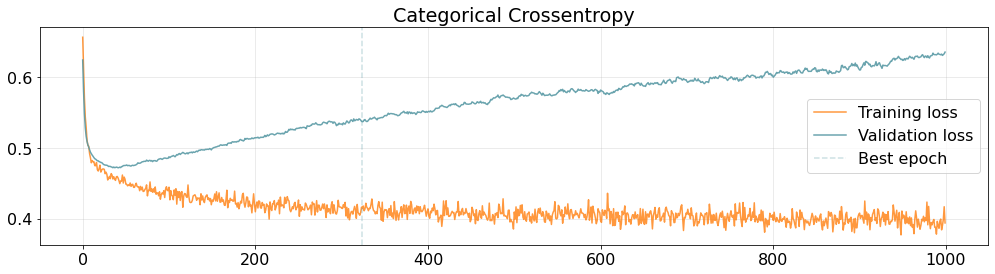

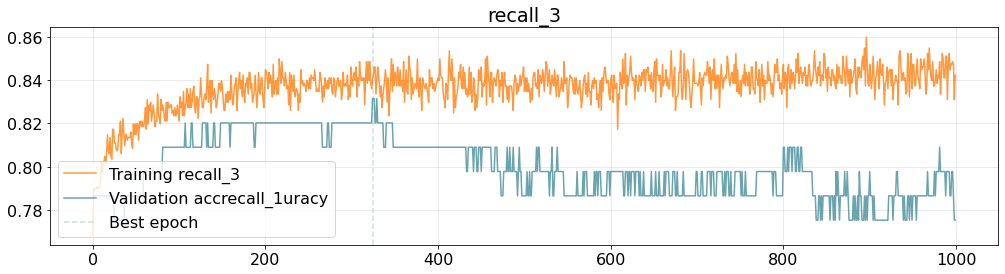

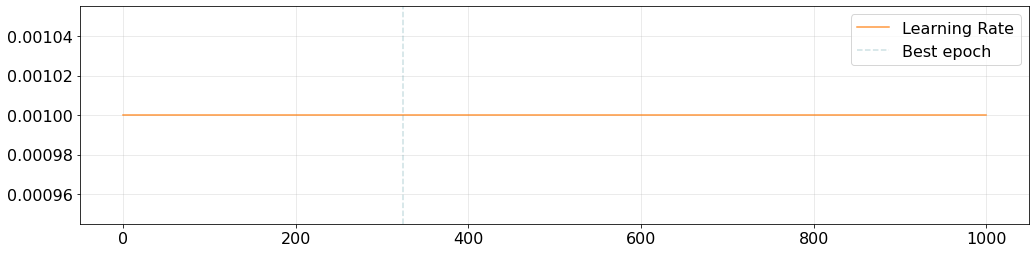

In [54]:
best_epoch = np.argmax(history['val_recall_3'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['recall_3'], label='Training recall_3', alpha=.8, color='#ff7f0e')
plt.plot(history['val_recall_3'], label='Validation accrecall_1uracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('recall_3')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Accuracy: 0.8063
Precision: 0.7889
Recall: 0.5913
F1: 0.6023


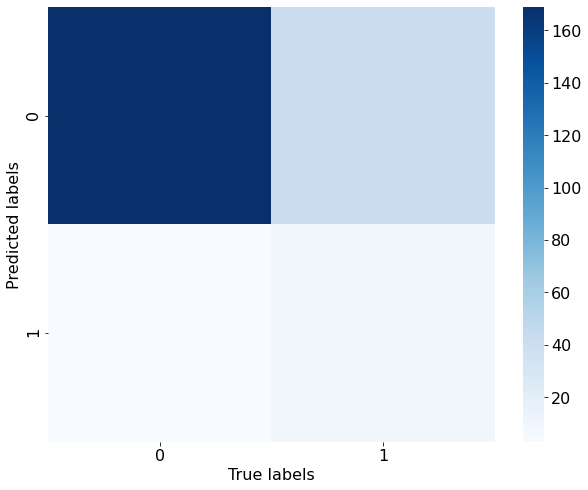

In [55]:
# Predict the test set with the LSTM
predictions = model.predict(X_test)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

The performance is quite bad, probably has to do with imbalance in the dataset and possible correlation among features. We decided to try something more fun than FFNNs :)